### Notebook Purpose

prototype dc regularization of intermediate layers

In [7]:
import os, sys
import h5py
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5, get_mask, num_params
from include.decoder_conv import init_convdecoder
from include.fit import fit
from include.subsample import MaskFunc
from utils.evaluate import calc_metrics
from utils.transform import fft_2d, ifft_2d, root_sum_squares, \
                            reshape_complex_vals_to_adj_channels, \
                            reshape_adj_channels_to_complex_vals, \
                            crop_center

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(0)
else:
    dtype = torch.FloatTensor

# TODO

- done: extracted feature maps
    - actually getting collapsed channels from original feature maps, i.e. 160 --> 30
- given ksp_masked, downsample according to the size of each intermediate layer
    - might want to normalize ksp_masked s.t. it matches the (mean, std) of the intermediate layer
- incorporate this with some loss function into fit()

### first prototype ways of extracting feature maps (intermediate layer outputs)

In [148]:
class Conv_Model(nn.Module):
    def __init__(self, num_layers, num_channels, out_depth, hidden_size,
                 upsample_mode='nearest', kernel_size=3, bias=False):

        super(Conv_Model, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.upsample_mode = upsample_mode

        # define layer types
        self.conv = nn.Conv2d(num_channels, num_channels, kernel_size, \
                         stride=1, padding=1, bias=bias)
        self.bn = nn.BatchNorm2d(num_channels, affine=True)
        self.collapse_channels = nn.Conv2d(num_channels, out_depth, 1, 1, padding=0, bias=bias)
        
        self.upsamp_list = []
        for size in hidden_size:
            self.upsamp_list.append(nn.Upsample(size=size, mode=upsample_mode))

    def forward(self, x):
        ''' run input thru net1 (convdecoder) then net2 (converts number of channels)
        provide options for skip connections (default False) and scaling factors (default 1) '''
        
        feat_maps = []
        
        for upsamp in self.upsamp_list:
            x = self.bn(F.relu(self.conv(upsamp(x))))
            feat_maps.append(self.collapse_channels(x)[0])
        
        # last layer: collapse channels, don't upsample
        x = self.collapse_channels(self.bn(F.relu(self.conv(x))))

        return x, feat_maps

In [149]:
from include.decoder_conv import get_scale_factor, get_net_input, get_hidden_size

def init_convdecoder(ksp_orig, mask, \
                     in_size=[8,4], num_layers=8, num_channels=160, kernel_size=3):
    ''' wrapper function for initializing convdecoder based on input ksp_orig

        parameters:
                ksp_orig: original, unmasked k-space measurements
                mask: mask used to downsample original k-space
        return:
                net: initialized convdecoder
                net_input: random, scaled input seed
                ksp_orig: scaled version of input '''

    out_size = ksp_orig.shape[1:] # shape of (x,y) image slice, e.g. (640, 368)
    out_depth = ksp_orig.shape[0]*2 # 2*n_c, i.e. 2*15=30 if multi-coil
    hidden_size = get_hidden_size(in_size, out_size, num_layers) # list of intermed layer sizes

    torch.manual_seed(0)
    net = Conv_Model(num_layers, num_channels, out_depth, hidden_size).type(dtype)
#     print('# parameters of ConvDecoder:',num_params(net))

    net_input = get_net_input(num_channels, in_size)

    # create scaled ksp to be compatible w network magnitude
    scale_factor = get_scale_factor(net, net_input, ksp_orig)
    ksp_orig_ = ksp_orig * scale_factor

    return net, net_input, ksp_orig_


In [150]:
def fit(ksp_masked, img_masked, net, net_input, mask2d, num_iter, lr=0.01):

    net_input = net_input.type(dtype)
    best_net = copy.deepcopy(net)
    best_mse = 10000.0
    mse_wrt_ksp, mse_wrt_img = np.zeros(num_iter), np.zeros(num_iter)

    p = [x for x in net.parameters()]
    optimizer = torch.optim.Adam(p, lr=lr,weight_decay=0)
    mse = torch.nn.MSELoss()

    # convert complex [nc,x,y] --> real [2*nc,x,y] to match w net output
    ksp_masked = reshape_complex_vals_to_adj_channels(ksp_masked).cuda()
    img_masked = reshape_complex_vals_to_adj_channels(img_masked)[None,:].cuda()
    mask2d = mask2d.cuda()

    for i in range(num_iter):
        def closure(): # execute this for each iteration (gradient step)

            optimizer.zero_grad()

            out, _ = net(net_input) # out is in img space
            out_ksp_masked = forwardm(out, mask2d).cuda() # convert img to ksp, apply mask

            #if DC_STEP: # ... see code inlay at bottom of file
            loss_ksp = mse(out_ksp_masked, ksp_masked)

            loss_ksp.backward(retain_graph=False)

            # store loss over each iteration
            mse_wrt_ksp[i] = loss_ksp.data.cpu().numpy()
            loss_img = mse(out, img_masked) # loss in img space
            mse_wrt_img[i] = loss_img.data.cpu().numpy()

            return loss_ksp

        loss = optimizer.step(closure)

        # at each iteration, check if loss improves by 1%. if so, a new best net
        loss_val = loss.data
        if best_mse > 1.005*loss_val:
            best_mse = loss_val
            best_net = copy.deepcopy(net)

    return best_net, mse_wrt_ksp, mse_wrt_img


def forwardm(img, mask):
    ''' convert img --> ksp (must be complex for fft), apply mask
        input, output should have dim [2*nc,x,y] '''

    img = reshape_adj_channels_to_complex_vals(img[0])
    ksp = fft_2d(img).cuda()
    ksp_masked_ = ksp * mask

    return reshape_complex_vals_to_adj_channels(ksp_masked_)

In [152]:
DIM = 320
SCALE_FAC = 0.1

file_id_list = ['1000273']#, '1000325', '1000464', '1000007', '1000537', '1000818', \
#                  '1001140', '1001219', '1001338', '1001598', '1001533', '1001798']
file_id_list.sort()


for file_id in file_id_list:

    f, ksp_orig = load_h5(file_id)
    ksp_orig = torch.from_numpy(ksp_orig)

    mask = get_mask(ksp_orig)

    net, net_input, ksp_orig_ = init_convdecoder(ksp_orig, mask)

    ksp_masked = SCALE_FAC * ksp_orig_ * mask
    img_masked = ifft_2d(ksp_masked)

    net, mse_wrt_ksp, mse_wrt_img = fit(
        ksp_masked=ksp_masked, img_masked=img_masked,
        net=net, net_input=net_input, mask2d=mask, num_iter=10000)


    # use above two lines when we don't want to access feature maps
#     img_out = net(net_input.type(dtype))
#     img_out = img_out[0] if type(img_out) is tuple else img_out
    img_out, feat_maps = net(net_input.type(dtype))

    img_out = reshape_adj_channels_to_complex_vals(img_out[0])
    ksp_est = fft_2d(img_out)
    ksp_dc = torch.where(mask, ksp_masked, ksp_est)

    img_est = crop_center(root_sum_squares(ifft_2d(ksp_est)).detach(), DIM, DIM)
    img_dc = crop_center(root_sum_squares(ifft_2d(ksp_dc)).detach(), DIM, DIM)
    img_gt = crop_center(root_sum_squares(ifft_2d(ksp_orig)), DIM, DIM)
#     print('note: use unscaled ksp_orig to make gt -- different from old fastmri processing')

#     np.save('{}{}_est.npy'.format(path_out, file_id), img_est)
#     np.save('{}{}_dc.npy'.format(path_out, file_id), img_dc)
#     np.save('{}{}_gt.npy'.format(path_out, file_id), img_gt)

[(15, 8), (28, 15), (53, 28), (98, 53), (183, 102), (343, 193), torch.Size([640, 368])]


In [153]:
for fm in feat_maps:
    print(fm.shape)

torch.Size([30, 15, 8])
torch.Size([30, 28, 15])
torch.Size([30, 53, 28])
torch.Size([30, 98, 53])
torch.Size([30, 183, 102])
torch.Size([30, 343, 193])
torch.Size([30, 640, 368])


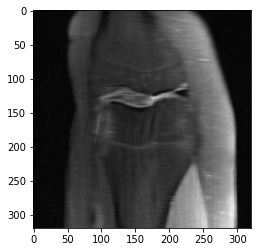

In [154]:
plt.imshow(img_dc, cmap='gray')
plt.show()